# Taller 7 Red Neuronal MLP


Enlace de del desarroyo mostrado en este cuaderno:      <a href="https://colab.research.google.com/github/JCardenas05/Teoria_Se-ales/blob/main/Taller_5/Taller_7_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab This NoteBook"/></a>


### A continuación se presenta una alternativa de solución en el siguiente enlace

Desarrollo del ejercido implementando una red *MLPClassifier* del paquete de skakearn, esta implementa un algoritmo de perceptrón multicapa (MLP) que se entrena utilizando Retropropagación (Backpropagation):        <a href="https://colab.research.google.com/github/JCardenas05/Teoria_Se-ales/blob/main/14-11-2023/Ejercicio_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab This NoteBook"/></a>


---

- Jony Cardenas Herrera
- Brayan Avendaño Mesa

## Actividades
1. Crear una red neuronal multicapa (MLP)
    - Modelo implementado: red de clasificación binaria
    - Generación de datos
    - Normalización
    - Entrenamiento
    - Validación 
    
2. Evaluar el rendimiento para distintas representaciones de datos
    - $p(0) = p(1)$
    - $p(0) >> p(1)$
    - $N_1(x_1, \sigma_1) \neq N_2(x_2, \sigma_2) $
3. Agregar metricas de rendimiento
    - Matrix de confusión
    - Accuracy
    - Loss

In [266]:
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [380]:
def map_range(value, min_=0, max_=1):
    """
    Normaliza los valores de una matriz 'value' a un rango especificado por 'min_' y 'max_'.

    Parámetros:
    - value (array-like): Matriz de valores a normalizar.
    - min_ (float, opcional): Valor mínimo del rango de salida. Por defecto es 0.
    - max_ (float, opcional): Valor máximo del rango de salida. Por defecto es 1.

    Retorna:
    - array-like: Matriz de valores normalizados en el nuevo rango.
    """
    return ((value-np.min(value))/(np.max(value)-np.min(value))) * (max_ - min_)

def clearConsole():
    command = 'clear'  # Comando por defecto para sistemas Unix/Linux
    os.system(command)  # Ejecuta el comando para limpiar la consola

def predict_simbol(message_corrupt, modelo, Nsamples=500, simbols=(0,1)):
    """
    Predice símbolos binarios a partir de un mensaje corrupto utilizando un modelo de predicción.

    Parámetros:
    - message_corrupt (array-like): Mensaje corrupto que se necesita predecir.
    - modelo (modelo de aprendizaje automático): Modelo de predicción utilizado.
    - Nsamples (int, opcional): Número de muestras. Por defecto es 500.
    - simbols (tuple, opcional): Tupla con los símbolos binarios. Por defecto es (0,1).

    Retorna:
    - array-like: Mensaje predicho en forma de matriz de símbolos binarios.
    """
    message_predict = modelo.predict(message_corrupt).flatten()
    message_predict = np.where(message_predict >= 0.5, simbols[1], simbols[0])
    message_predict = np.repeat(message_predict, Nsamples)
    return message_predict

def generate_symbols(a0=0, a1=1, p_0=0.5, Nsamples=500, Nsymbols=100, var_noise=0.5, Diff=False):
    """
    Genera símbolos con ruido y los prepara para pruebas.

    Parámetros:
    - a0, a1 (float, opcional): Valores de los símbolos. Por defecto son 0 y 1.
    - p_0 (float, opcional): Probabilidad del símbolo 'a0'. Por defecto es 0.5.
    - Nsamples (int, opcional): Número de muestras por símbolo. Por defecto es 500.
    - Nsymbols (int, opcional): Número de símbolos. Por defecto es 100.
    - var_noise (float o tuple, opcional): Varianza del ruido. Puede ser un número o una tupla. Por defecto es 0.5.
    - Diff (bool, opcional): Si es True, aplica diferencia entre muestras consecutivas.

    Retorna:
    - tuple: Tres matrices correspondientes a los mensajes corruptos, los mensajes originales y el tiempo.
    """

    N=Nsamples*Nsymbols
    p_1 = 1 - p_0

    if type(var_noise) == tuple:
        data_test = np.random.choice([a0, a1], size=Nsymbols, p=[p_0, p_1])
        message_test_org = np.concatenate([[v]*Nsamples for v in data_test])
        message_test_corrupt = []

        noise_test_a0 = np.random.normal(0, var_noise[0], sum([1 for x in message_test_org if x == a0]))
        noise_test_a1 = np.random.normal(0, var_noise[1], sum([1 for x in message_test_org if x == a1]))

        for i in message_test_org:

            if i == a0:
                noise_simbol = noise_test_a0[0]
                noise_test_a0 = np.delete(noise_test_a0, 0)
            elif i == a1:
                noise_simbol = noise_test_a1[0]
                noise_test_a1 = np.delete(noise_test_a1, 0)

            message_test_corrupt.append(i + noise_simbol)
        message_test_corrupt = np.array(message_test_corrupt)
        
    else:
        noise_test = np.random.normal(0, var_noise, N)
        data_test = np.random.choice([a0, a1], size=Nsymbols, p=[p_0, p_1])
        message_test_org = np.concatenate([[v]*Nsamples for v in data_test])
        message_test_corrupt = message_test_org + noise_test
        message_test_corrupt = map_range(message_test_corrupt)

    message_test_corrupt = np.array(np.split(message_test_corrupt, Nsymbols))

    if Diff == True:
        message_test_org_ = np.array(np.split(message_test_org, Nsymbols))
        message_test_org_ = np.abs(np.diff(message_test_org_, axis=0, prepend=0))
        message_test_corrupt = message_test_org_.flatten() + noise_test
        message_test_corrupt = map_range(message_test_corrupt)
        message_test_corrupt = np.array(np.split(message_test_corrupt, Nsymbols))
        message_test_org_ = message_test_org_.flatten()
        message_test_org = (message_test_org, message_test_org_)

    time = np.linspace(0,N,N)
    return message_test_corrupt, message_test_org, time    

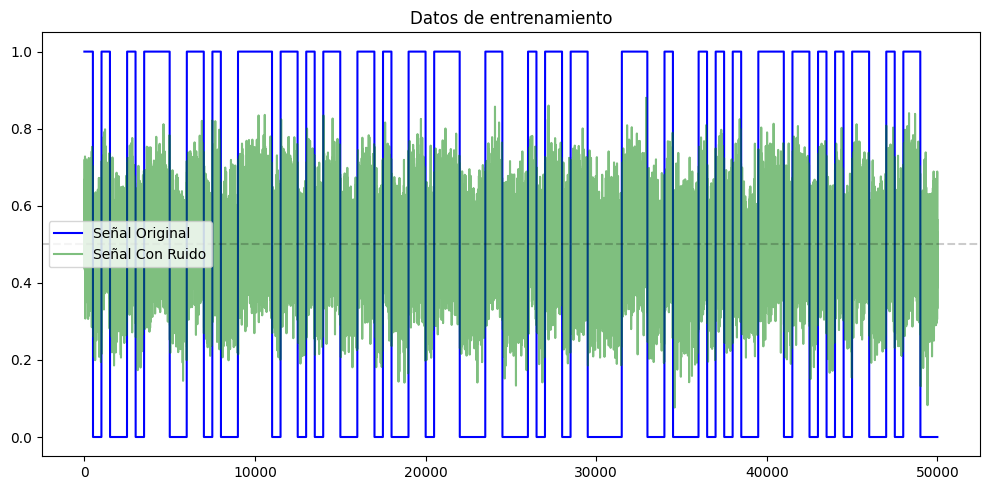

In [340]:
a1 = 1       # Valor del símbolo a1
a0 = 0    # Valor del símbolo a0

# Probabilidades de los símbolos
p_0 = 0.5
p_1 = 1 - p_0

Nsamples = 500
Nsymbols = 6000 # Número total de símbolos
N = Nsymbols * Nsamples  # Número total de muestras

o1 = 1
noise = np.random.normal(0, o1, N)
time = np.linspace(0, Nsamples*100, Nsamples*100)

data_test = np.random.choice([a0, a1], size=Nsymbols, p=[p_0, p_1])
message_org = np.concatenate([[v]*Nsamples for v in data_test])
message_corrupt = message_org + noise

#message_test_orig = map_range(message_test_orig)
message_corrupt = map_range(message_corrupt)

message_org = np.array(np.split(message_org, Nsymbols))
message_corrupt = np.array(np.split(message_corrupt, Nsymbols))

plt.figure(figsize=(10,5),tight_layout=True) 
plt.title("Datos de entrenamiento")
plt.plot(time,message_org[:100].flatten(), color='blue', alpha=(1), label='Señal Original')
plt.plot(time,message_corrupt[:100].flatten(), color='green', alpha=0.5, label=f'Señal Con Ruido' )
plt.axhline((a0+a1)/2, color=(0,0,0,0.2), linestyle='--')  
plt.legend()
plt.show()

In [269]:
X_train, X_val, y_train, y_val = train_test_split(message_corrupt, message_org, test_size=0.2, random_state=42)
print(f'Señal Corrupta entrenamiento: {X_train.shape}')
print(f'Señal Original entrenamiento: {y_train.shape}')
print(f'Señal Corrupta validación: {X_val.shape}')
print(f'Señal Original validación: {y_val.shape}')

Señal Corrupta entrenamiento: (4800, 500)
Señal Original entrenamiento: (4800, 500)
Señal Corrupta validación: (1200, 500)
Señal Original validación: (1200, 500)


Epoch 1/60
150/150 [==============================] - 2s 5ms/step - loss: 0.2482 - accuracy: 0.5102 - val_loss: 0.2539 - val_accuracy: 0.4900
Epoch 2/60
150/150 [==============================] - 1s 5ms/step - loss: 0.2476 - accuracy: 0.5048 - val_loss: 0.2478 - val_accuracy: 0.5650
Epoch 3/60
150/150 [==============================] - 1s 4ms/step - loss: 0.2453 - accuracy: 0.5217 - val_loss: 0.2423 - val_accuracy: 0.5108
Epoch 4/60
150/150 [==============================] - 1s 4ms/step - loss: 0.2433 - accuracy: 0.5492 - val_loss: 0.2412 - val_accuracy: 0.6117
Epoch 5/60
150/150 [==============================] - 1s 5ms/step - loss: 0.2407 - accuracy: 0.5421 - val_loss: 0.2369 - val_accuracy: 0.5708
Epoch 6/60
150/150 [==============================] - 1s 4ms/step - loss: 0.2389 - accuracy: 0.5717 - val_loss: 0.2378 - val_accuracy: 0.5108
Epoch 7/60
150/150 [==============================] - 1s 4ms/step - loss: 0.2347 - accuracy: 0.5821 - val_loss: 0.2302 - val_accuracy: 0.8017
Epoch 

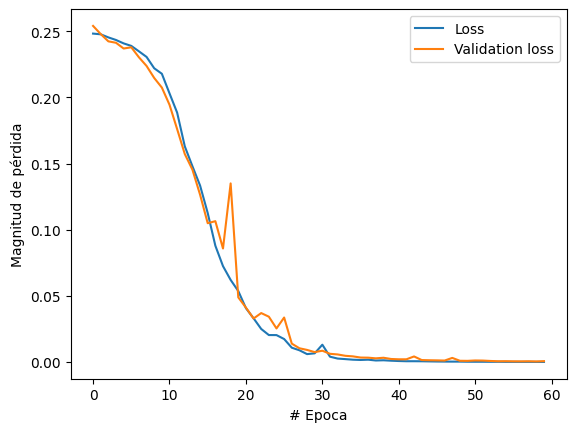

In [270]:

entrada = tf.keras.layers.Dense(units=200, input_shape=(Nsamples,))
capa1   = tf.keras.layers.Dense(units=100, activation='relu')
capa2   = tf.keras.layers.Dense(units=70, activation='relu')
capa3   = tf.keras.layers.Dense(units=50, activation='relu')
salida  = tf.keras.layers.Dense(units=1, activation='sigmoid')
modelo  = tf.keras.Sequential([entrada, capa1, capa2, capa3, salida])

# Compilación del modelo
modelo.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
               loss=tf.keras.losses.mean_squared_error,
               metrics=['accuracy']
              )

historial = modelo.fit(X_train, y_train, epochs=60, validation_data=(X_val, y_val))

clearConsole()

plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"], label='Loss')
plt.plot(historial.history["val_loss"], label = 'Validation loss' )
plt.legend()
plt.show()

## 1) Generar simboloas con la misma probabiliadd $P(0) = P(1)$

2/2 [==============================] - 0s 4ms/step


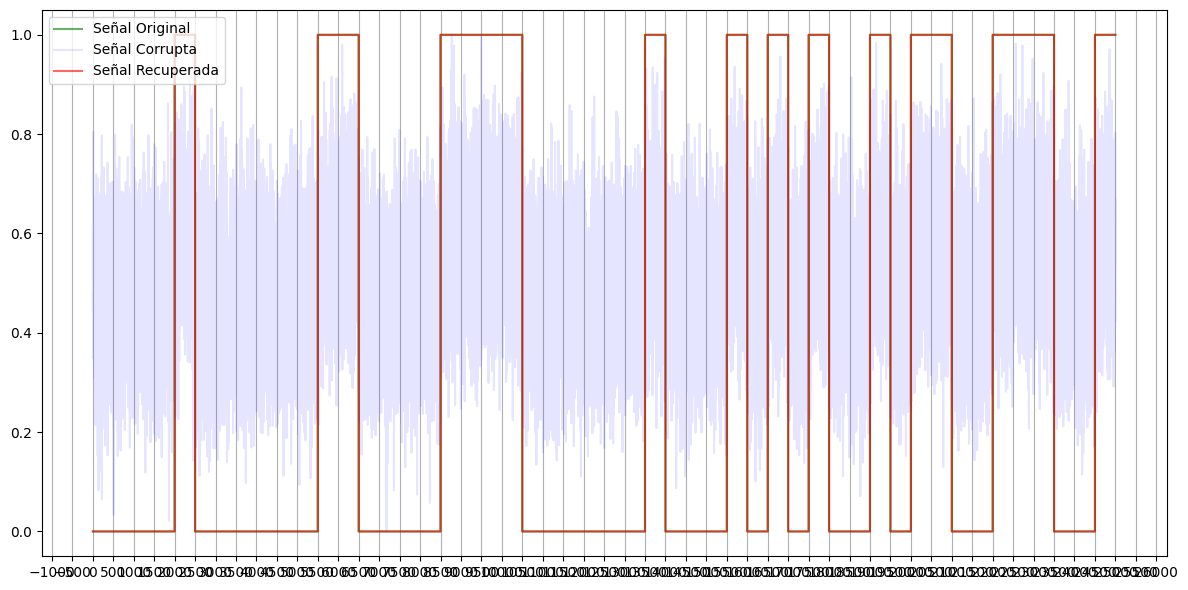

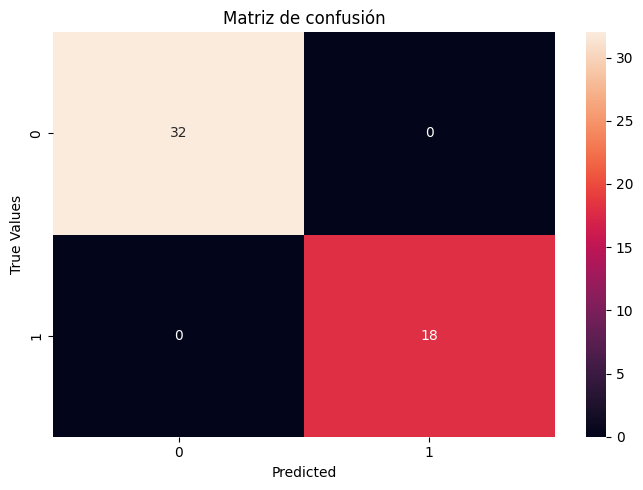

In [271]:
Nsamples = 500
message_test_corrupt_1, message_test_orig_1, time_1 = generate_symbols(Nsymbols=50, Nsamples=Nsamples, var_noise=1) 
message_predict_1 = predict_simbol(message_test_corrupt_1, modelo, 500)

plt.figure(figsize=(12,6),tight_layout=True)  #modificar el tamaño (x,y)
plt.step(time_1,message_test_orig_1, 'g', label='Señal Original', alpha=0.6)
plt.step(time_1,message_test_corrupt_1.flatten(), 'b', label='Señal Corrupta', alpha=0.1)
plt.step(time_1,message_predict_1, 'r', label='Señal Recuperada', alpha=0.6)
plt.legend()
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(Nsamples))
plt.grid(axis='x')  # Solo cuadrícula vertical
plt.show()

matrix_1 = confusion_matrix(message_test_orig_1, message_predict_1)/Nsamples
plt.figure(figsize=(7,5),tight_layout=True)  #modificar el tamaño (x,y)
sns.heatmap(matrix_1, annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True Values')
plt.show()

## 2) Generar una secuencia de simbolos $0$ y $1$ con $P(0) >> p(1)$

4/4 [==============================] - 0s 3ms/step


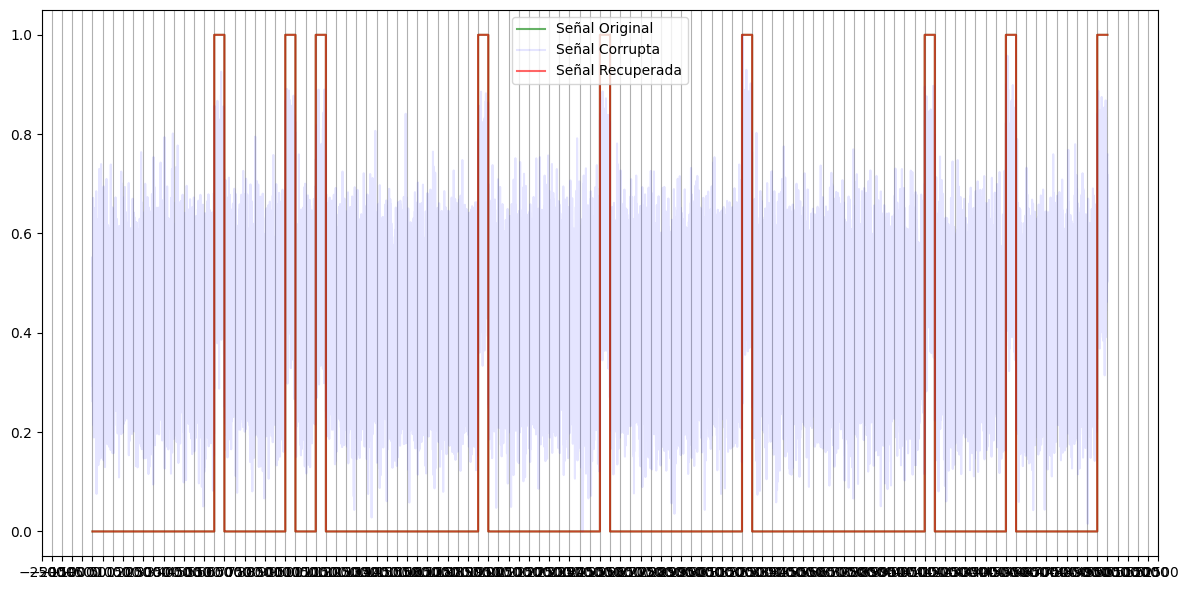

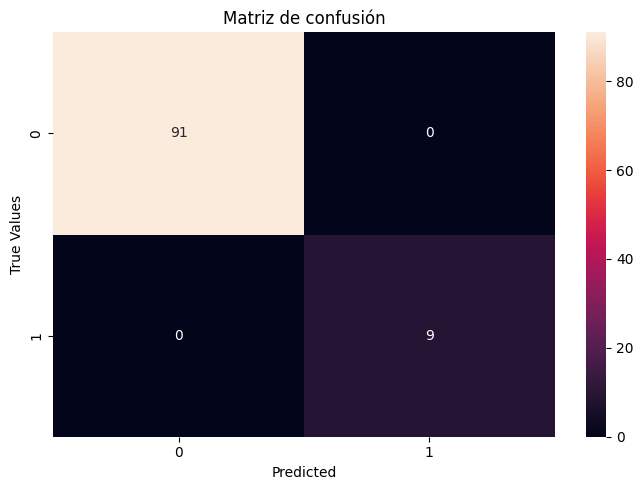

In [272]:
p_0 = 0.9
message_test_corrupt_2, message_test_orig_2, time_2 = generate_symbols(p_0=p_0, Nsymbols=100, var_noise=0.5) 

message_predict_2 = modelo.predict(message_test_corrupt_2)
message_predict_2 = message_predict_2.flatten()
message_predict_2 = np.where(message_predict_2 >= 0.5, 1, 0)
message_predict_2 = np.array([[x]*Nsamples for x in message_predict_2])
message_predict_2 = message_predict_2.flatten()
 
plt.figure(figsize=(12,6),tight_layout=True)  #modificar el tamaño (x,y)
plt.step(time_2,message_test_orig_2, 'g', label='Señal Original', alpha=0.6)
plt.step(time_2,message_test_corrupt_2.flatten(), 'b', label='Señal Corrupta', alpha=0.1)
plt.step(time_2,message_predict_2, 'r', label='Señal Recuperada', alpha=0.6)
plt.legend()
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(Nsamples))
plt.grid(axis='x')  # Solo cuadrícula vertical
plt.show()

matrix_2 = confusion_matrix(message_test_orig_2, message_predict_2)/Nsamples
plt.figure(figsize=(7,5),tight_layout=True)  #modificar el tamaño (x,y)
sns.heatmap(matrix_2, annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True Values')
plt.show()


## 3) Ruidos con varianza difernete para cada simbolo: $N_1(x_1, \sigma_1) \neq N_2(x_2, \sigma_2) $

4/4 [==============================] - 0s 3ms/step


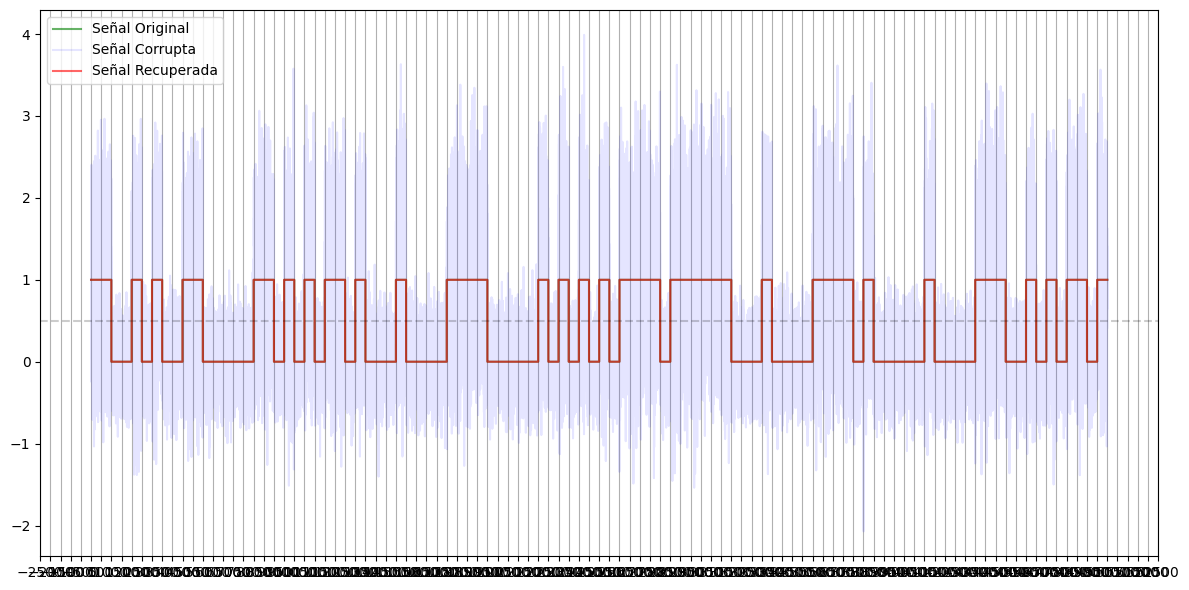

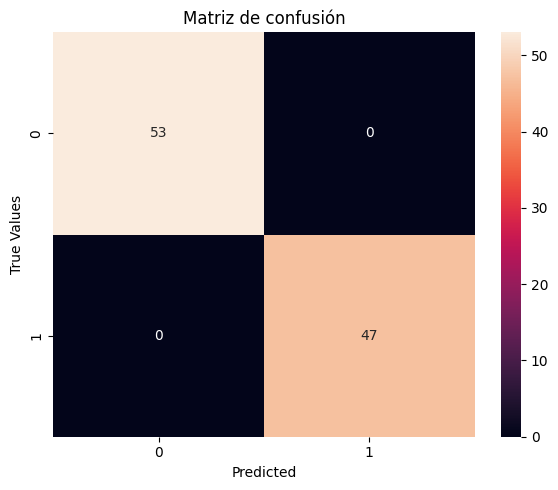

In [361]:
message_test_corrupt_3, message_test_orig_3, time_3 = generate_symbols(Nsymbols=100, p_0=0.5, Nsamples=Nsamples, var_noise=(0.3, 0.7)) 
message_predict_3 = predict_simbol(message_test_corrupt_3, modelo, 500)

plt.figure(figsize=(12,6),tight_layout=True)  #modificar el tamaño (x,y)
plt.step(time_3,message_test_orig_3, 'g', label='Señal Original', alpha=0.6)
plt.step(time_3,message_test_corrupt_3.flatten(), 'b', label='Señal Corrupta', alpha=0.1)
plt.step(time_3,message_predict_3, 'r', label='Señal Recuperada', alpha=0.6)
plt.legend()
plt.axhline((a0+a1)/2, color=(0,0,0,0.2), linestyle='--') 
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(Nsamples))
plt.grid(axis='x')  #cuadrícula por símbolo
plt.show()

matrix_3 = confusion_matrix(message_test_orig_3, message_predict_3)/Nsamples
plt.figure(figsize=(6,5),tight_layout=True)  #modificar el tamaño (x,y)
sns.heatmap(matrix_3, annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True Values')
plt.show()

## 4) Representación Diferencial: $N_1(0,\sigma_1)-N_2(0,\sigma_2)=0$  

1/1 [==============================] - 0s 41ms/step


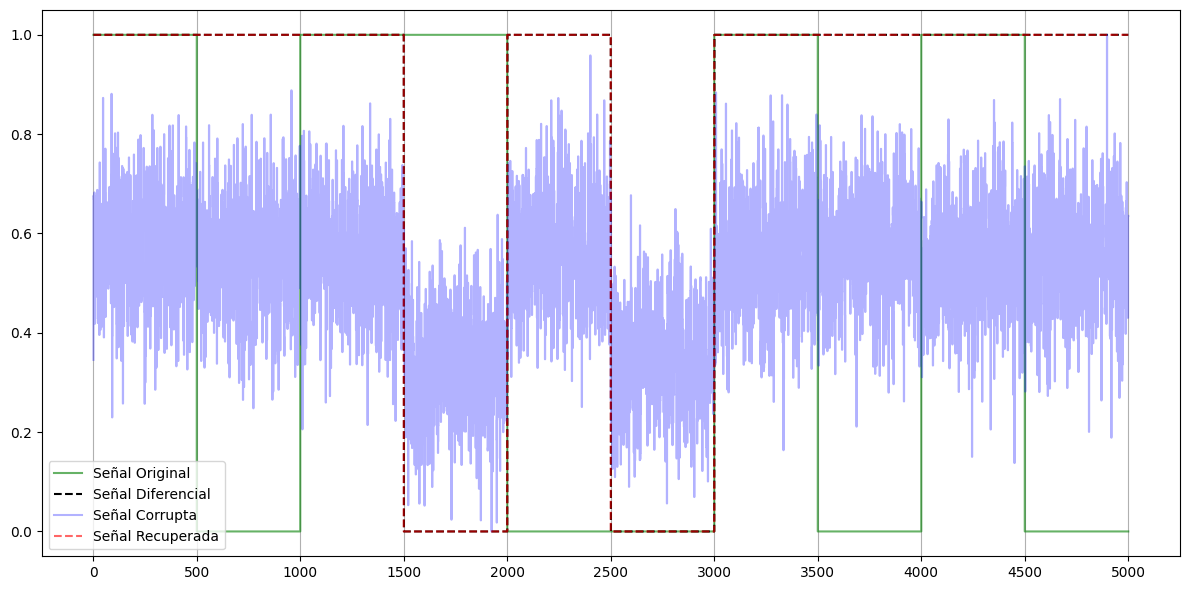

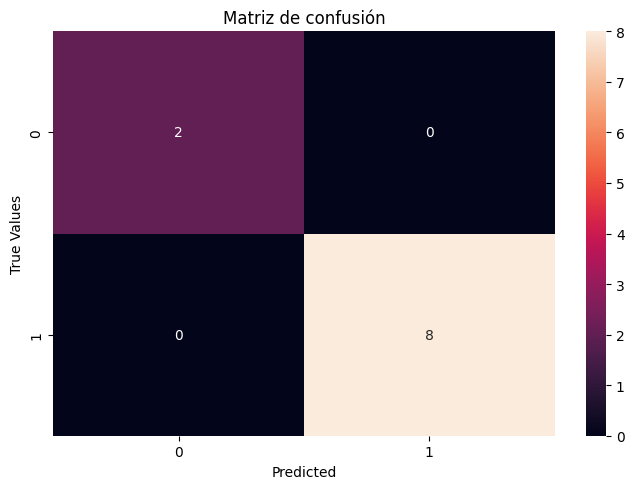

In [383]:
Nsamples = 500
message_test_corrupt_4, message_test_orig_4, time_4 = generate_symbols(Nsymbols=10, Nsamples=Nsamples, var_noise=0.5, Diff=True) 
message_predict_4 = predict_simbol(message_test_corrupt_4, modelo, 500)

plt.figure(figsize=(12,6),tight_layout=True)  #modificar el tamaño (x,y)
plt.step(time_4, message_test_orig_4[0], 'g', label='Señal Original', alpha=0.6)
plt.plot(time_4, message_test_orig_4[1], '--', color = 'black',label='Señal Diferencial', alpha=1)
plt.step(time_4, message_test_corrupt_4.flatten(), 'b', label='Señal Corrupta', alpha=0.3)
plt.step(time_4, message_predict_4, '--r', label='Señal Recuperada', alpha=0.6)
plt.legend()
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(Nsamples))
plt.grid(axis='x')  # Solo cuadrícula vertical
plt.show()

matrix_4 = confusion_matrix(message_test_orig_4[1], message_predict_4)/Nsamples
plt.figure(figsize=(7,5),tight_layout=True)  #modificar el tamaño (x,y)
sns.heatmap(matrix_4, annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True Values')
plt.show()

